In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/public_assault/dataset/violence.zip -d .
!unzip /content/drive/MyDrive/public_assault/dataset/handclapping.zip -d handclapping
!unzip /content/drive/MyDrive/public_assault/dataset/handwaving.zip  -d handwaving
!unzip /content/drive/MyDrive/public_assault/dataset/jogging.zip   -d jogging
!unzip /content/drive/MyDrive/public_assault/dataset/running.zip  -d running
!unzip /content/drive/MyDrive/public_assault/dataset/walking.zip  -d walking

In [ ]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import numpy as np


In [ ]:
import numpy as np
import cv2
import os
import pickle
import PIL
import re
from PIL import Image
import imageio
from skimage.transform import resize
from keras.models import load_model

In [ ]:
CATEGORIES = [
    "violence",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]
IMG_W_ORIGINAL = 120
IMG_H_ORIGINAL = 160
IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
SPACIALNET_INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
TEMPORALNET_INPUT_SHAPE = (SEQ_LEN-1, IMG_W//2, IMG_H//2, CHANNELS)
TEMPORALNET_INPUT_SHAPE_2x = (2 * (SEQ_LEN-1), IMG_W//2, IMG_H//2, CHANNELS)
NCLASSES = 6

In [ ]:
Train_Id = [1,4,6,7,8,10,11,13,14,15,16,17,18,19,21,22,23]
Validation_Id = [2,5,9,20,24,25]
Test_Id = [3,12]

In [ ]:
def clean_sequence_file():
    print("Cleaning dataset/00sequences.txt ...")

    # Read 00sequences.txt file.
    with open("/content/drive/MyDrive/public_assault/00sequences.txt", 'r') as content_file:
      for _ in range(20): # Skiping first 20 lines of sequences file (instruction details).
        next(content_file)
      content = content_file.read()

    # Replace tab and newline character with space, then split file's content
    # into strings.
    content = re.sub("[\t\n]", " ", content).split()

    # Dictionary to keep ranges of frames with humans.
    # Example:
    # video "person01_boxing_d1": [(1, 95), (96, 185), (186, 245), (246, 360)].
    frames_idx = {}

    # Current video that we are parsing.
    current_filename = ""

    for s in content:
        if s == "frames":
            # Ignore this token.
            continue
        elif s.find("-") >= 0:
            # This is the token we are looking for. e.g. 1-95.
            if s[len(s) - 1] == ',':
                # Remove comma.
                s = s[:-1]

            # Split into 2 numbers => [1, 95]
            idx = s.split("-")

            # Add to dictionary.
            if not current_filename in frames_idx:
                frames_idx[current_filename] = []
            frames_idx[current_filename].append((int(idx[0]), int(idx[1])))
        else:
            # Parse next file.
            current_filename = s + "_uncomp.avi"

    return frames_idx


# Pixel feature extraction

In [ ]:
def prepare_dataset(dataset="train", sequences=None):
    if dataset == "train":
        ID = Train_Id
    elif dataset == "dev":
        ID = Validation_Id
    else:
        ID = Test_Id

    if sequences == None:
      frames_idx = clean_sequence_file()
    else:
      frames_idx = sequences

    data = []
    for category in CATEGORIES:
        if category == "violence":
            # Get all files in current category's folder.
            folder_path = os.path.join("/content/"+"picked_dataset/" +category)
            filenames = sorted(os.listdir(folder_path))

            for filename in filenames:
                if filename == ".ipynb_checkpoints":
                    continue
                filepath ="/content/"+"picked_dataset/"+category+"/"+filename

                vid = imageio.get_reader(filepath, "ffmpeg")

                frames = []

                # Add each frame to correct list.
                for i, frame in enumerate(vid):
                    # Boolean flag to check if current frame contains human.
                    frame = cv2.resize(frame, (120, 160))


                    # Convert to grayscale.

                    frame = Image.fromarray(np.array(frame))
                    frame = frame.convert("L")
                    frame = np.array(frame.getdata(),
                                    dtype=np.uint8).reshape((120, 160))
                    frame = cv2.resize(frame, (60, 80))

                    frames.append(frame)

                data.append({
                    "filename": filename,
                    "category": category,
                    "frames": frames
            })
        else:
             # Get all files in current category's folder.
            folder_path = os.path.join("/content/"+"picked_dataset/"+category)
            filenames = sorted(os.listdir(folder_path))

            for filename in filenames:
                filepath ="/content/"+"picked_dataset/"+category+"/"+filename

                # Get id of person in this video.
                person_id = int(filename.split("_")[0][6:])
                if person_id not in ID:
                    continue

                vid = imageio.get_reader(filepath, "ffmpeg")

                frames = []

                # Add each frame to correct list.
                for i, frame in enumerate(vid):
                    # Boolean flag to check if current frame contains human.
                    ok = False
                    for seg in frames_idx[filename]:
                        if i >= seg[0] and i <= seg[1]:
                            ok = True
                            break
                    if not ok:
                        continue

                    # Convert to grayscale.
                    frame = Image.fromarray(np.array(frame))
                    frame = frame.convert("L")
                    frame = np.array(frame.getdata(),
                                    dtype=np.uint8).reshape((120, 160))
                    frame = cv2.resize(frame, (60, 80))

                    frames.append(frame)

                data.append({
                    "filename": filename,
                    "category": category,
                    "frames": frames
            })


    pickle.dump(data, open("/content/drive/MyDrive/public_assault/pixel_feature/%s.p" % dataset, "wb+"))


In [ ]:
extracted_sequences = clean_sequence_file()
print("Preparing train dataset ...")
prepare_dataset(dataset="train", sequences=extracted_sequences)
print("Preparing dev dataset ...")
prepare_dataset(dataset="dev", sequences=extracted_sequences)
print("Preparing test dataset ...")
prepare_dataset(dataset="test", sequences=extracted_sequences)

Cleaning dataset/00sequences.txt ...
Preparing train dataset ...
Preparing dev dataset ...
Preparing test dataset ...


In [ ]:

print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/MyDrive/public_assault/pixel_feature/train.p", "rb"))
validation_videos = pickle.load(open("/content/drive/MyDrive/public_assault/pixel_feature/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/MyDrive/public_assault/pixel_feature/test.p", "rb"))


Loading dataset ..


# Optical flow feature extraction

In [ ]:
def extract_optflow(dataset="train"):
    if dataset == "train":
        ID = Train_Id
    elif dataset == "dev":
        ID = Validation_Id
    else:
        ID = Test_Id

    # Setup parameters for optical flow.
    farneback_params = dict(
        winsize=20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

    frames_idx = clean_sequence_file()

    data = []

    for category in CATEGORIES:
        if category == "violence":
            folder_path = os.path.join("/content/"+"picked_dataset/" +category)
            filenames = sorted(os.listdir(folder_path))

            for filename in filenames:
                if filename == ".ipynb_checkpoints":
                    continue
                filepath ="/content/"+"picked_dataset/"+category+"/"+filename

                vid = imageio.get_reader(filepath, "ffmpeg")

                flow_x = []
                flow_y = []

                prev_frame = None
                for i, frame in enumerate(vid):

                    frame = cv2.resize(frame, (120, 160))
                    # Convert to grayscale.
                    frame = Image.fromarray(np.array(frame))
                    frame = frame.convert("L")
                    frame = np.array(frame.getdata(),
                                    dtype=np.uint8).reshape((IMG_W_ORIGINAL, IMG_H_ORIGINAL))
                    frame = resize(frame, (IMG_W, IMG_H))
                    if prev_frame is not None:
                        # Calculate optical flow.
                        flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,
                                                            **farneback_params)

                        # Subsampling optical flow by half (due to memory usage problems).
                        subsampled_x = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                        subsampled_y = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                        for r in range(IMG_W//2):
                            for c in range(IMG_H//2):
                                subsampled_x[r, c] = flows[r*2, c*2, 0]
                                subsampled_y[r, c] = flows[r*2, c*2, 1]

                        flow_x.append(subsampled_x)
                        flow_y.append(subsampled_y)

                    prev_frame = frame

                data.append({
                    "filename": filename,
                    "category": category,
                    "flow_x": flow_x,
                    "flow_y": flow_y
                })
        else:
            folder_path = os.path.join("/content/"+"picked_dataset/" +category)
            filenames = sorted(os.listdir(folder_path))

            for filename in filenames:
                filepath ="/content/"+"picked_dataset/"+category+"/"+filename

                person_id = int(filename.split("_")[0][6:])
                if person_id not in ID:
                    continue

                vid = imageio.get_reader(filepath, "ffmpeg")

                flow_x = []
                flow_y = []

                prev_frame = None
                for i, frame in enumerate(vid):
                    ok = False
                    for seg in frames_idx[filename]:
                        if i >= seg[0] and i <= seg[1]:
                            ok = True
                            break
                    if not ok:
                        continue

                    # Convert to grayscale.
                    frame = Image.fromarray(np.array(frame))
                    frame = frame.convert("L")
                    frame = np.array(frame.getdata(),
                                    dtype=np.uint8).reshape((IMG_W_ORIGINAL, IMG_H_ORIGINAL))
                    frame = resize(frame, (IMG_W, IMG_H))

                    if prev_frame is not None:
                        # Calculate optical flow.
                        flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,
                                                            **farneback_params)

                        # Subsampling optical flow by half (due to memory usage problems).
                        subsampled_x = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                        subsampled_y = np.zeros((IMG_W//2, IMG_H//2), dtype=np.float32)
                        for r in range(IMG_W//2):
                            for c in range(IMG_H//2):
                                subsampled_x[r, c] = flows[r*2, c*2, 0]
                                subsampled_y[r, c] = flows[r*2, c*2, 1]

                        flow_x.append(subsampled_x)
                        flow_y.append(subsampled_y)

                    prev_frame = frame

                data.append({
                    "filename": filename,
                    "category": category,
                    "flow_x": flow_x,
                    "flow_y": flow_y
                })


    pickle.dump(data, open("/content/drive/MyDrive/public_assault/temporal_feature/%s_flow.p" % dataset, "wb"))

In [ ]:
print("Extracting train optflow ...")
extract_optflow(dataset="train")
print("Extracting dev optflow ...")
extract_optflow(dataset="dev")
print("Extracting test optflow ...")
extract_optflow(dataset="test")

In [ ]:
def read_ds(ds="train", separate_each_video=False):
  if(ds == "dev"):
    videos = validation_videos
    video_flows = pickle.load(open("/content/drive/MyDrive/public_assault/temporal_feature/dev_flow.p", "rb"))
  elif (ds == "test"):
    videos = test_videos
    video_flows = pickle.load(open("/content/drive/MyDrive/public_assault/temporal_feature/test_flow.p", "rb"))
  else:
    videos = train_videos
    video_flows = pickle.load(open("/content/drive/MyDrive/public_assault/temporal_feature/train_flow.p", "rb"))

  mean_frames = 0
  mean_flow_x = 0
  mean_flow_y = 0

  X = []
  y = []
  i=0
  X_per_video = []
  y_per_video = []
  print("total videos : %s" % len(videos))

  for video_index in range(len(videos)):
    seq_frame = []
    seq_flow_x = []
    seq_flow_y = []

    frames = videos[video_index]["frames"]
    flow_x = [0] + video_flows[video_index]["flow_x"]
    flow_y = [0] + video_flows[video_index]["flow_y"]

    for frame_index in range(len(frames)):
      seq_frame.append(frames[frame_index])

      if frame_index % SEQ_LEN > 0:
        seq_flow_x.append(flow_x[frame_index])
        seq_flow_y.append(flow_y[frame_index])

      if (frame_index + 1) % SEQ_LEN == 0:
        #print(seq_flow_x)
        seq_frame = np.array(seq_frame, dtype=np.float32).reshape(SPACIALNET_INPUT_SHAPE)
        seq_flow_x = np.array(seq_flow_x, dtype=np.float32).reshape(TEMPORALNET_INPUT_SHAPE)
        seq_flow_y = np.array(seq_flow_y, dtype=np.float32).reshape(TEMPORALNET_INPUT_SHAPE)

        mean_frames += np.mean(seq_frame)
        mean_flow_x += np.mean(seq_flow_x)
        mean_flow_y += np.mean(seq_flow_y)

        X.append({
            "frames": seq_frame,
            "flow_x": seq_flow_x,
            "flow_y": seq_flow_y
        })

        y.append(
            CATEGORIES.index(videos[video_index]["category"]))

        seq_frame = []
        seq_flow_x = []
        seq_flow_y = []


    if(separate_each_video):
      X_per_video.append(np.array(X))
      y_per_video.append(np.array(y, dtype=np.uint8))
      X = []
      y = []

  mean_frames /= len(X)
  mean_flow_x /= len(X)
  mean_flow_y /= len(X)

  mean = {
      "frames": mean_frames,
      "flow_x": mean_flow_x,
      "flow_y": mean_flow_y
  }

  if(separate_each_video):
     return np.array(X_per_video), np.array(y_per_video), mean

  y = np.array(y, dtype=np.uint8)
  return X, y, mean


In [ ]:
X_train_data, y_train, X_train_data_mean = read_ds(ds="train")
X_dev_data, y_dev, X_dev_data_mean = read_ds(ds="dev")
X_test_data, y_test, X_test_data_mean= read_ds(ds="test")

total videos : 399
total videos : 240
total videos : 160


In [ ]:
X_train, train_flow_x, train_flow_y = np.array([ _['frames'] for _ in X_train_data]), np.array([ _['flow_x'] for _ in X_train_data]), np.array([ _['flow_y'] for _ in X_train_data])
X_dev, dev_flow_x, dev_flow_y = np.array([ _['frames'] for _ in X_dev_data]), np.array([ _['flow_x'] for _ in X_dev_data]), np.array([ _['flow_y'] for _ in X_dev_data])
X_test, test_flow_x, test_flow_y = np.array([ _['frames'] for _ in X_test_data]), np.array([ _['flow_x'] for _ in X_test_data]), np.array([ _['flow_y'] for _ in X_test_data])


Visualize the data

[1487]
(1, 3, 30, 40, 1)
----------------------------------------------------------------------------------------------------
Grayscale Images : 


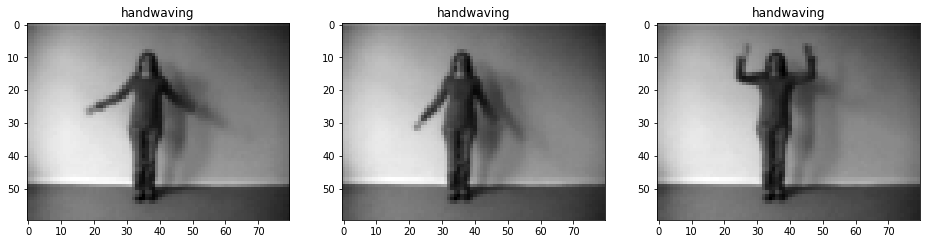

----------------------------------------------------------------------------------------------------
Farneback Flow x Images : 


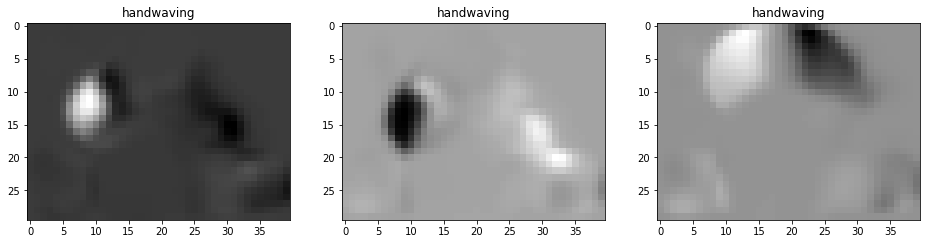

----------------------------------------------------------------------------------------------------
Farneback Flow y Images : 


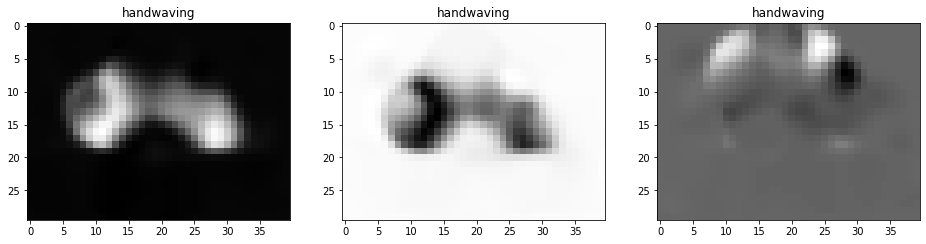

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(16,12))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    #fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()



imgs_samples_size = 1
imgs_samples = np.random.randint(X_train.shape[0] - 1, size=imgs_samples_size)
imgs_per_samples = 3

imgs_gray_class = []
imgs_gray = []
imgs_flow_x = []
imgs_flow_y = []
for i in range(len(imgs_samples)):
  imgs_gray.append(X_train[imgs_samples[i]][0:SEQ_LEN:SEQ_LEN//imgs_per_samples])
  imgs_flow_x.append(train_flow_x[imgs_samples[i]][0:SEQ_LEN-1:SEQ_LEN//imgs_per_samples])
  imgs_flow_y.append(train_flow_y[imgs_samples[i]][0:SEQ_LEN-1:SEQ_LEN//imgs_per_samples])

#show_images(imgs_gray, cols = 1, titles = "Grayscale Images")

print(imgs_samples)
img_sample = imgs_samples[0]


print(np.array(imgs_flow_y).shape)
#plt.show(imgs_gray[img_sample].reshape(IMG_W, IMG_H))


reshaped_imgs_gray = []
reshaped_imgs_flow_x = []
reshaped_imgs_flow_y = []
for i in range(len(imgs_samples)):
  for j in range(len(imgs_gray[i])):
    imgs_gray_class.append(CATEGORIES[y_train[imgs_samples[i]]])
    reshaped_imgs_gray.append(imgs_gray[i][j].reshape(IMG_W, IMG_H))
    reshaped_imgs_flow_x.append(imgs_flow_x[i][j].reshape(IMG_W//2, IMG_H//2))
    reshaped_imgs_flow_y.append(imgs_flow_y[i][j].reshape(IMG_W//2, IMG_H//2))

print("-"*100)
print("Grayscale Images : ")
show_images(reshaped_imgs_gray, cols = imgs_samples_size, titles = imgs_gray_class)
print("-"*100)
print("Farneback Flow x Images : ")
show_images(reshaped_imgs_flow_x, cols = imgs_samples_size, titles = imgs_gray_class)
print("-"*100)
print("Farneback Flow y Images : ")
show_images(reshaped_imgs_flow_y, cols = imgs_samples_size, titles = imgs_gray_class)

Convolution Neural Network 3d model

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import concatenate, Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add, GlobalAveragePooling1D
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam,SGD
from keras.layers import average, concatenate, Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add, GlobalAveragePooling1D


In [ ]:

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)


In [ ]:
def get_3dmodel(name, input_shape, get_feature_vector=True):

    # 3D CNN model (VGG Action)
    inputs = Input(shape=input_shape)
    conv1_1 = Conv3D(16,(1,3,3),activation='relu', name='conv1_1_{}'.format(name))(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv3D(16,(1,3,3),activation='relu',padding='same', name='conv1_2_{}'.format(name))(bn1_1)
    pool1_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool1_1_{}'.format(name))(conv1_2)

    conv2_1 = Conv3D(32,(1,3,3),activation='relu',padding='same', name='conv2_1_{}'.format(name))(pool1_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv3D(32,(1,3,3),activation='relu',padding='same', name='conv2_2_{}'.format(name))(bn2_1)
    pool2_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool2_1_{}'.format(name))(conv2_2)

    conv3_1 = Conv3D(64,(1,3,3),activation='relu',padding='same', name='conv3_1_{}'.format(name))(pool2_1)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv3D(64,(1,3,3),activation='relu',padding='same', name='conv3_2_{}'.format(name))(bn3_1)
    pool3_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool3_1_{}'.format(name))(conv3_2)

    conv4_1 = Conv3D(128,(1,3,3),activation='relu',padding='same', name='conv4_1_{}'.format(name))(pool3_1)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv3D(128,(1,3,3),activation='relu',padding='same', name='conv4_2_{}'.format(name))(bn4_1)
    pool4_1 = MaxPooling3D(pool_size=(2,2,2),padding='valid', name='pool4_1_{}'.format(name))(conv4_2)

    flatten = Flatten()(pool4_1)
    dense4_1 = Dense(512,activation='relu', name='fc4_1_{}'.format(name))(flatten)
    dropout4_1 = Dropout(0.3)(dense4_1)
    bn4_1 = BatchNormalization()(dropout4_1)
    dropout4_2 = Dropout(0.5)(bn4_1)
    dense4_2 = Dense(256,activation='relu', name='fc4_2_{}'.format(name))(dropout4_2)

    if get_feature_vector:
      return dense4_2, inputs
    dropout4_3 = Dropout(0.5)(dense4_2)
    dense4_3 = Dense(NCLASSES, name='fc4_3_{}'.format(name))(dropout4_3)
    softmax = Activation('softmax')(dense4_3)

    return Model(inputs=inputs, outputs=softmax), inputs

In [ ]:

spatial_net, spatial_input = get_3dmodel(name='spatial_net', input_shape = SPACIALNET_INPUT_SHAPE, get_feature_vector=False)
temporal_net, temporal_input = get_3dmodel(name='temporal_net', input_shape = TEMPORALNET_INPUT_SHAPE_2x, get_feature_vector=False)

inputs = [spatial_net.input, temporal_net.input]
outputs = average([spatial_net.output, temporal_net.output])
model = Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 60, 80,  0           []                               
                                 1)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 58, 30, 40,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv1_1_spatial_net (Conv3D)   (None, 30, 58, 78,   160         ['input_1[0][0]']                
                                16)                                                         

In [ ]:

train_spatial_data = X_train
train_temporal_data = np.concatenate((train_flow_x, train_flow_y), axis=1)


dev_spatial_data = X_dev
dev_temporal_data = np.concatenate((dev_flow_x, dev_flow_y), axis=1)


test_spatial_data = X_test
test_temporal_data = np.concatenate((test_flow_x, test_flow_y), axis=1)

train_spatial_data.shape, train_temporal_data.shape

((3960, 30, 60, 80, 1), (3960, 58, 30, 40, 1))

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/public_assault/model.h5"
checkpointer = ModelCheckpoint(checkpoint_filepath,monitor='val_accuracy',mode='max',verbose=1, save_best_only=True)

model.compile(optimizer = Adam(0.001),loss='categorical_crossentropy', metrics=['accuracy'])

trained_model = model.fit([train_spatial_data,train_temporal_data ], y_train, epochs = 100, batch_size = 16, validation_data=([dev_spatial_data,dev_temporal_data ], y_dev),callbacks = [checkpointer])

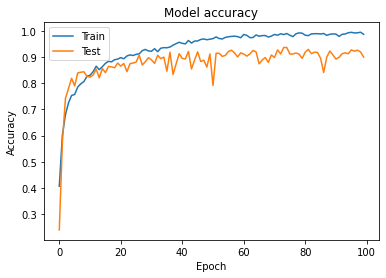

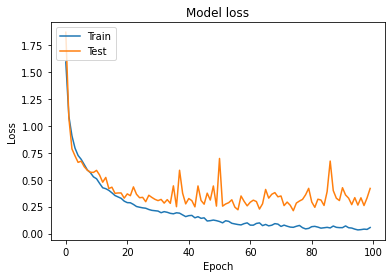

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


38/38 [==============================] - 3s 76ms/step


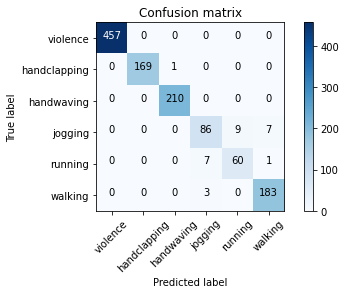

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
model = load_model("/content/drive/MyDrive/public_assault/model.h5")
Y_pred = model.predict([test_spatial_data, test_temporal_data])
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES)


In [ ]:
tp,fp,fn,tn

In [ ]:
tp/tp+fp

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names=CATEGORIES))

              precision    recall  f1-score   support

    violence       1.00      1.00      1.00       457
handclapping       1.00      0.99      1.00       170
  handwaving       1.00      1.00      1.00       210
     jogging       0.90      0.84      0.87       102
     running       0.87      0.88      0.88        68
     walking       0.96      0.98      0.97       186

    accuracy                           0.98      1193
   macro avg       0.95      0.95      0.95      1193
weighted avg       0.98      0.98      0.98      1193



In [ ]:
model = load_model("/content/drive/MyDrive/public_assault/model.h5")
Y_pred = model.predict([test_spatial_data, test_temporal_data])
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test, axis = 1)
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(Y_true, Y_pred_classes)
print('Accuracy:', accuracy_score)

Accuracy: 0.9765297569153395
